<a href="https://colab.research.google.com/github/jacksone1/DataSci/blob/main/DataSciUnit6Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Install and import datasets, xarray, and bambi libraries
!pip install datasets
from datasets import load_dataset

!pip install git+https://github.com/pydata/xarray.git
import xarray as xr

!pip install bambi
import bambi as bmb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [3]:
#Import other libraries
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sb

In the game Super Mario Maker 2, players design their own Mario levels and share them online for others to play. The world record clear time among all the players of a level is kept and displayed by the game. I intend to predict the world record clear time of levels based on several level characteristics.

These characteristics will be:

*   Autoscroll speed: the speed, from 0 to 2, at which the screen moves to the right during gameplay. If this is zero, the player can freely set their own pace. One means slow, and two means fast.
*   clear_condition: one of many requirements a creator may impose on their players before they can finish a level.
*   timer: the maximum alotted time for level completion.
*   gamestyle: the version of Mario used for the level, such as "Super Mario Bros." or "New Super Mario Bros. U." These versions have slight variations in level layout possibilities.
*   tags: the creator's choice of two descriptive tags for their level out of 16 options.
*   upload_attempts: the number of attempts it took the creator to complete their level.
*   upload_time: the time it took for the creator to complete their level.
*   clears: the number of successful attempts of a level among all players.
*   attempts: the number of attempts of a level among all players.
*   clear_rate: The proportion of clears out of attempts.

# Data Collection

The Mario Maker 2 data used for this project was acquired from https://huggingface.co/datasets/TheGreatRambler/mm2_level. The dataset contains a variety of information about player uploaded levels.

The dataset is too large to load quickly in its entirety, so it is loaded in streaming mode, which means only part of the dataset is loaded at a time. 1000 entries of level data are acquired and shuffled, before the desired level characteristics are recorded in a dictionary. The dictionary is then converted to a pandas dataframe.

The random seed used for acquiring the data was generated from Random.org's random integer generator from 1 to 100 (both inclusive) at 2025-01-23 18:59:25 UTC

In [4]:
#Read Mario Maker data
mario_levels = load_dataset("TheGreatRambler/mm2_level", streaming=True, split="train")
#Shuffle data
shuffled_levels = mario_levels.shuffle(buffer_size=1_000, seed=58)
#Get the data as a list to iterate over
sample = list(shuffled_levels.take(1000))
#Create a dictionary to hold difficulties anc clear rate
level_data_dict = {
    "autoscroll_speed": [],
    "clear_condition": [],
    "timer": [],
    "gamestyle": [],
    "tags": [],
    "upload_attempts": [],
    "upload_time": [],
    "clears": [],
    "attempts": [],
    "clear_rate": [],
    "world_record": []
}
#For each element of the list, record the relevant level data
for i in range(0, 1000):
  level_data_dict["autoscroll_speed"].append(sample[i]["autoscroll_speed"])
  level_data_dict["clear_condition"].append(sample[i]["clear_condition"])
  level_data_dict["timer"].append(sample[i]["timer"])
  level_data_dict["gamestyle"].append(sample[i]["gamestyle"])
  #Combine the two level tags into a bitmask
  #Tags in the data are numbered 0-15
  #Bitwise shift 0b1 to the left by the tag number for each tag, then bitwise OR the values together
  level_data_dict["tags"].append((1<<sample[i]["tag1"]) | (1<<sample[i]["tag2"]))
  level_data_dict["upload_attempts"].append(sample[i]["upload_attempts"])
  level_data_dict["upload_time"].append(sample[i]["upload_time"])
  level_data_dict["clears"].append(sample[i]["clears"])
  level_data_dict["attempts"].append(sample[i]["attempts"])
  level_data_dict["clear_rate"].append(sample[i]["clear_rate"])
  level_data_dict["world_record"].append(sample[i]["world_record"])

#Convert the dictionary to a pandas dataframe
level_data_df = pd.DataFrame(level_data_dict)
#Recognize categories
level_data_df["autoscroll_speed"] = level_data_df["autoscroll_speed"].astype('category')
level_data_df["clear_condition"] = level_data_df["clear_condition"].astype('category')
level_data_df["gamestyle"] = level_data_df["gamestyle"].astype('category')
level_data_df["tags"] = level_data_df["tags"].astype('category')
#Display the dataframe
level_data_df

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/196 [00:00<?, ?it/s]

dataset_infos.json:   0%|          | 0.00/5.51k [00:00<?, ?B/s]

,autoscroll_speed,clear_condition,timer,gamestyle,tags,upload_attempts,upload_time,clears,attempts,clear_rate,world_record
0,0,0,300,1,68,1,11220,37,83,44.578313,6446
1,0,0,300,3,4,1,41383,8,14,57.142857,2399
2,0,0,500,1,320,9,42484,10,2305,0.433839,45495
3,0,0,300,3,272,6,70183,7,132,5.303030,62368
4,0,0,300,4,1,2,27085,76,189,40.211640,6502
...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,120,3,6,2,26555,2,3,66.666667,31536
996,0,0,300,0,1,2,42366,16,40,40.000000,24740
997,0,0,300,0,1,5,34828,2,26,7.692308,51411
998,0,0,500,4,68,30,293663,2,94,2.127660,297405


In [5]:
#Remove nonsensical world record columns
level_data_df.query("0 <= world_record / 1000 <= 500", inplace = True)
level_data_df

,autoscroll_speed,clear_condition,timer,gamestyle,tags,upload_attempts,upload_time,clears,attempts,clear_rate,world_record
0,0,0,300,1,68,1,11220,37,83,44.578313,6446
1,0,0,300,3,4,1,41383,8,14,57.142857,2399
2,0,0,500,1,320,9,42484,10,2305,0.433839,45495
3,0,0,300,3,272,6,70183,7,132,5.303030,62368
4,0,0,300,4,1,2,27085,76,189,40.211640,6502
...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,120,3,6,2,26555,2,3,66.666667,31536
996,0,0,300,0,1,2,42366,16,40,40.000000,24740
997,0,0,300,0,1,5,34828,2,26,7.692308,51411
998,0,0,500,4,68,30,293663,2,94,2.127660,297405


array([[<Axes: xlabel='timer', ylabel='timer'>,
        <Axes: xlabel='upload_attempts', ylabel='timer'>,
        <Axes: xlabel='upload_time', ylabel='timer'>,
        <Axes: xlabel='clears', ylabel='timer'>,
        <Axes: xlabel='attempts', ylabel='timer'>,
        <Axes: xlabel='clear_rate', ylabel='timer'>,
        <Axes: xlabel='world_record', ylabel='timer'>],
       [<Axes: xlabel='timer', ylabel='upload_attempts'>,
        <Axes: xlabel='upload_attempts', ylabel='upload_attempts'>,
        <Axes: xlabel='upload_time', ylabel='upload_attempts'>,
        <Axes: xlabel='clears', ylabel='upload_attempts'>,
        <Axes: xlabel='attempts', ylabel='upload_attempts'>,
        <Axes: xlabel='clear_rate', ylabel='upload_attempts'>,
        <Axes: xlabel='world_record', ylabel='upload_attempts'>],
       [<Axes: xlabel='timer', ylabel='upload_time'>,
        <Axes: xlabel='upload_attempts', ylabel='upload_time'>,
        <Axes: xlabel='upload_time', ylabel='upload_time'>,
        <Axes:

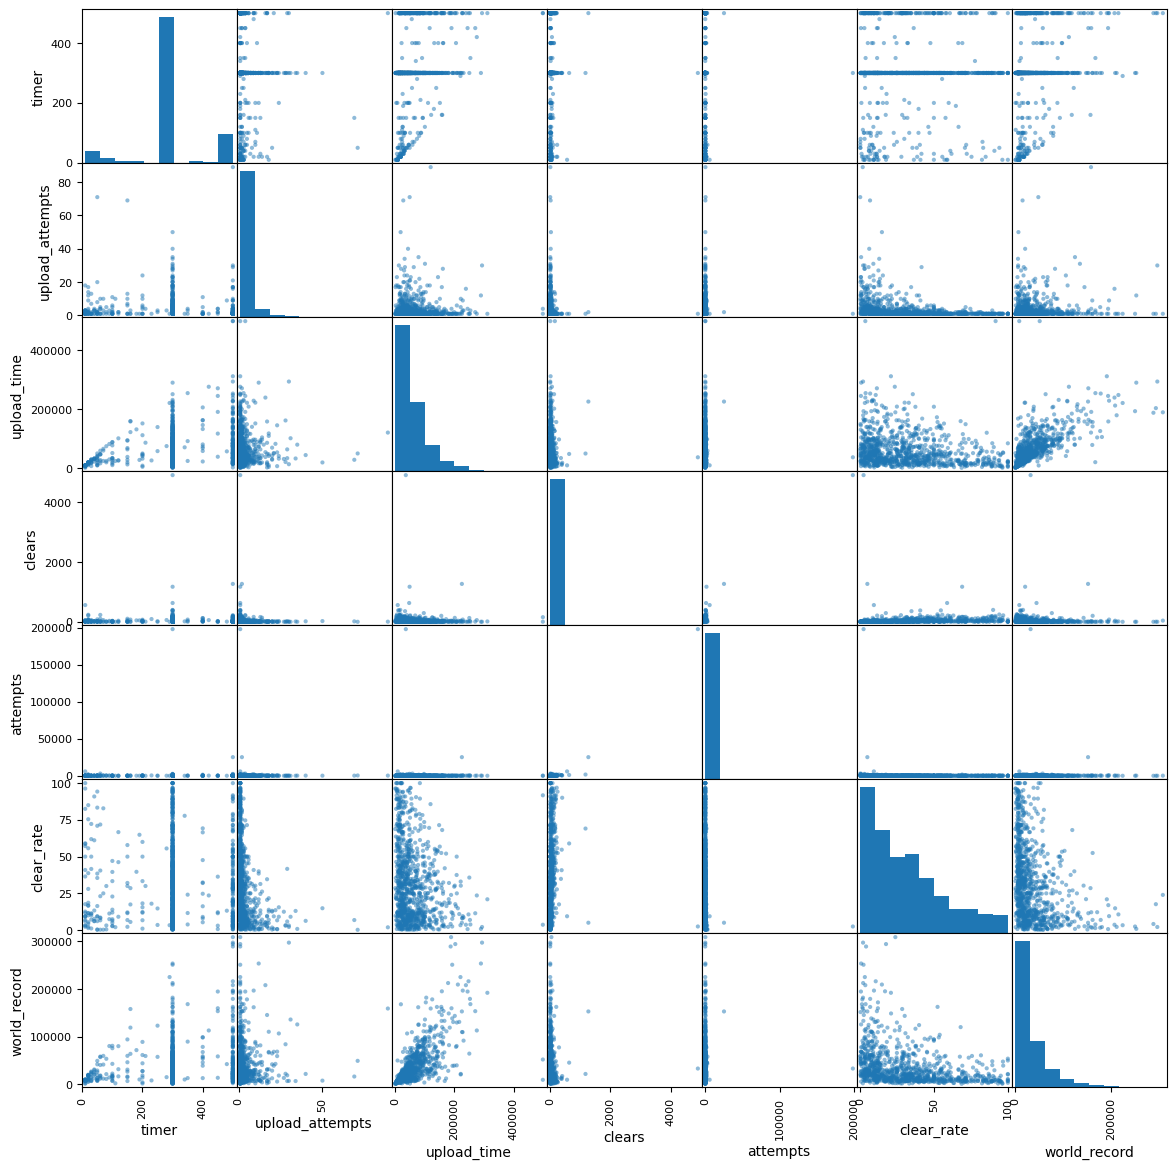

In [5]:
#scatter plots of predictors vs predicted
'''level_data_df.plot(x="autoscroll_speed", y="world_record", figsize=(4, 3), kind="scatter")
level_data_df.plot(x="clear_condition", y="world_record", figsize=(4, 3), kind="scatter")
level_data_df.plot(x="timer", y="world_record", figsize=(4, 3), kind="scatter")
level_data_df.plot(x="gamestyle", y="world_record", figsize=(4, 3), kind="scatter")
level_data_df.plot(x="tags", y="world_record", figsize=(4, 3), kind="scatter")
level_data_df.plot(x="upload_attempts", y="world_record", figsize=(4, 3), kind="scatter")
level_data_df.plot(x="upload_time", y="world_record", figsize=(4, 3), kind="scatter")
level_data_df.plot(x="attempts", y="world_record", figsize=(4, 3), kind="scatter")
level_data_df.plot(x="clears", y="world_record", figsize=(4, 3), kind="scatter")
level_data_df.plot(x="clear_rate", y="world_record", figsize=(4, 3), kind="scatter")
level_data_df.plot(x="autoscroll_speed", y="world_record", figsize=(4, 3), kind="scatter")'''
pd.plotting.scatter_matrix(level_data_df, figsize=(14,14))

The bottom row of the plot matrix shows the numerical predictors plotted against the world record. Note that upload attempts, upload time, clears, and attempts each seem to have high leverage outlier points. The models will be run without the removal of those points, and should they not perform well as a result, the outliers may be dropped.

# Model Creation and Comparison

In the following three cells, single variable models will be created and compared via elpd_loo so that the best variables can be determined for multiple predictor models.

In [9]:
#Create models for each individual predictor and return a list of idata
#Dataframe, predicted string
def GetSingleModels(df, predicted):
  #Create a dictionary for idata by formula
  single_models = {}
  #For each predictor column in the dataframe df
  for col in df:
    if(col != predicted):
      #Print the formula
      formula = predicted + " ~ " + col
      print("Creating model: " + formula)
      #Get the idata for the model
      current_model = bmb.Model(formula, data=df)
      current_idata = current_model.fit(idata_kwargs={"log_likelihood":True})
      #Record the idata in the dictionary with its formula as the key
      single_models[formula] = (current_model, current_idata)
  return(single_models)

single_models = GetSingleModels(level_data_df, "world_record")

Creating model: world_record ~ autoscroll_speed


Output()

Output()

Creating model: world_record ~ clear_condition


Output()

Output()

Creating model: world_record ~ timer


Output()

Output()

Creating model: world_record ~ gamestyle


Output()

Output()

Creating model: world_record ~ tags


Output()

Output()

Creating model: world_record ~ upload_attempts


Output()

Output()

Creating model: world_record ~ upload_time


Output()

Output()

Creating model: world_record ~ clears


Output()

Output()

Creating model: world_record ~ attempts


Output()

Output()

Creating model: world_record ~ clear_rate


Output()

Output()

In [10]:
single_idatas = dict(zip(single_models.keys(), (v[1] for v in single_models.values())))
single_compare = az.compare(single_idatas)
single_compare

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
world_record ~ upload_time,0,-11423.039209,22.734812,0.000000,9.995447e-01,72.035023,0.000000,True,log
world_record ~ tags,1,-11688.629288,66.663630,265.590078,4.552832e-04,49.664075,68.047900,True,log
world_record ~ clear_rate,2,-11690.845705,7.470293,267.806496,2.566788e-09,54.479867,59.811620,False,log
world_record ~ timer,3,-11714.939924,8.054873,291.900715,1.030347e-09,52.318469,58.866831,False,log
world_record ~ clear_condition,4,-11716.836494,38.976286,293.797285,1.697632e-09,52.019069,66.644689,True,log
world_record ~ gamestyle,5,-11725.525879,11.321501,302.486669,8.890450e-10,53.682507,59.710727,False,log
world_record ~ upload_attempts,6,-11741.950934,8.878839,318.911725,1.859816e-10,54.261636,59.505705,False,log
world_record ~ autoscroll_speed,7,-11745.419708,7.370098,322.380499,0.000000e+00,54.469795,59.612893,False,log
world_record ~ attempts,8,-11745.444895,7.615598,322.405686,0.000000e+00,54.433577,59.614814,True,log
world_record ~ clears,9,-11745.880449,8.984022,322.841240,0.000000e+00,54.572631,59.713114,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

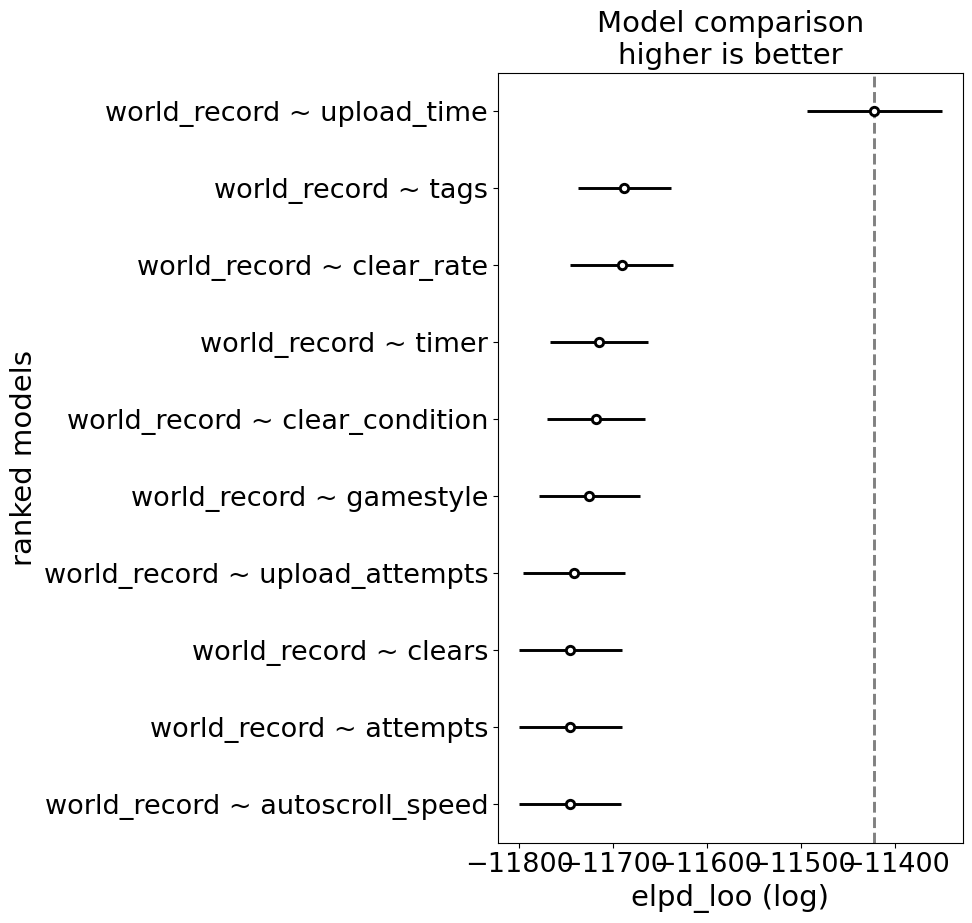

In [ ]:
az.plot_compare(single_compare)

With the exception of upload time, all of the single predictor models do very similarly well, which is quite unexpected. The mean line of attempts vs world record will be plotted to determine whether the potential high leverage points mentioned in the previous section may have distorted the model prediction too much.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


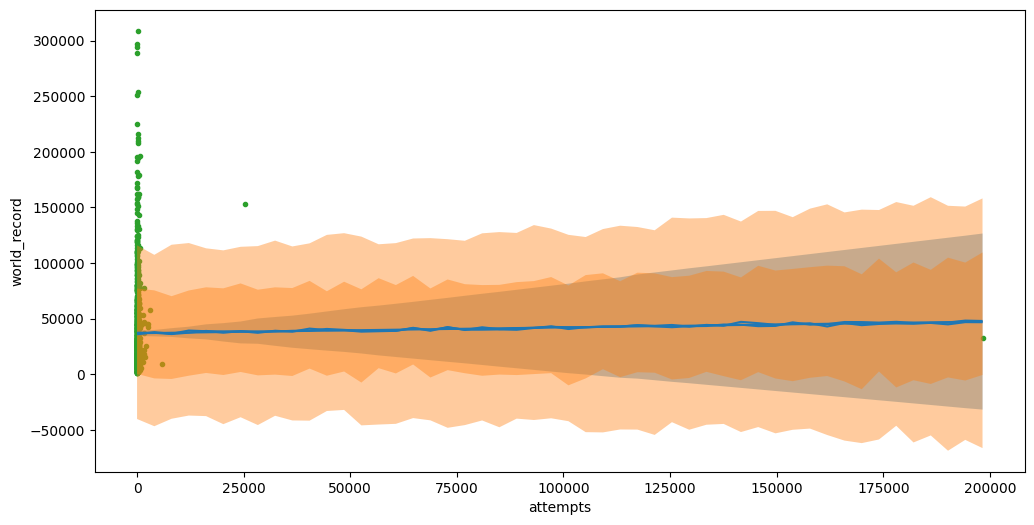

In [ ]:
#Plot two HDIs
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
#mean line
bmb.interpret.plot_predictions(single_models['world_record ~ attempts'][0], single_models['world_record ~ attempts'][1], "attempts", ax=ax, fig_kwargs={"color":"k"})
#94% HDI
bmb.interpret.plot_predictions(single_models['world_record ~ attempts'][0], single_models['world_record ~ attempts'][1], "attempts", pps=True, ax=ax)
#65% HDI
ax_ = bmb.interpret.plot_predictions(single_models['world_record ~ attempts'][0], single_models['world_record ~ attempts'][1], "attempts", pps=True, ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')

#raw data
ax.plot(level_data_df.attempts, level_data_df.world_record, "C2.", zorder=-3)

It seems that the outliers must be removed: the mean line is approximately horizontal due to the extreme leverage of the level with the greatest attempts, despite the trend in the other levels' attempts not seeming to match.

In [ ]:
#Remove extreme outliers and record the new dataframe.
level_data_2 = level_data_df.query("attempts < 5000")
level_data_2

,autoscroll_speed,clear_condition,timer,gamestyle,tags,upload_attempts,upload_time,clears,attempts,clear_rate,world_record
0,0,0,300,1,68,1,11220,37,83,44.578313,6446
1,0,0,300,3,4,1,41383,8,14,57.142857,2399
2,0,0,500,1,320,9,42484,10,2305,0.433839,45495
3,0,0,300,3,272,6,70183,7,132,5.303030,62368
4,0,0,300,4,1,2,27085,76,189,40.211640,6502
...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,120,3,6,2,26555,2,3,66.666667,31536
996,0,0,300,0,1,2,42366,16,40,40.000000,24740
997,0,0,300,0,1,5,34828,2,26,7.692308,51411
998,0,0,500,4,68,30,293663,2,94,2.127660,297405


array([[<Axes: xlabel='timer', ylabel='timer'>,
        <Axes: xlabel='upload_attempts', ylabel='timer'>,
        <Axes: xlabel='upload_time', ylabel='timer'>,
        <Axes: xlabel='clears', ylabel='timer'>,
        <Axes: xlabel='attempts', ylabel='timer'>,
        <Axes: xlabel='clear_rate', ylabel='timer'>,
        <Axes: xlabel='world_record', ylabel='timer'>],
       [<Axes: xlabel='timer', ylabel='upload_attempts'>,
        <Axes: xlabel='upload_attempts', ylabel='upload_attempts'>,
        <Axes: xlabel='upload_time', ylabel='upload_attempts'>,
        <Axes: xlabel='clears', ylabel='upload_attempts'>,
        <Axes: xlabel='attempts', ylabel='upload_attempts'>,
        <Axes: xlabel='clear_rate', ylabel='upload_attempts'>,
        <Axes: xlabel='world_record', ylabel='upload_attempts'>],
       [<Axes: xlabel='timer', ylabel='upload_time'>,
        <Axes: xlabel='upload_attempts', ylabel='upload_time'>,
        <Axes: xlabel='upload_time', ylabel='upload_time'>,
        <Axes:

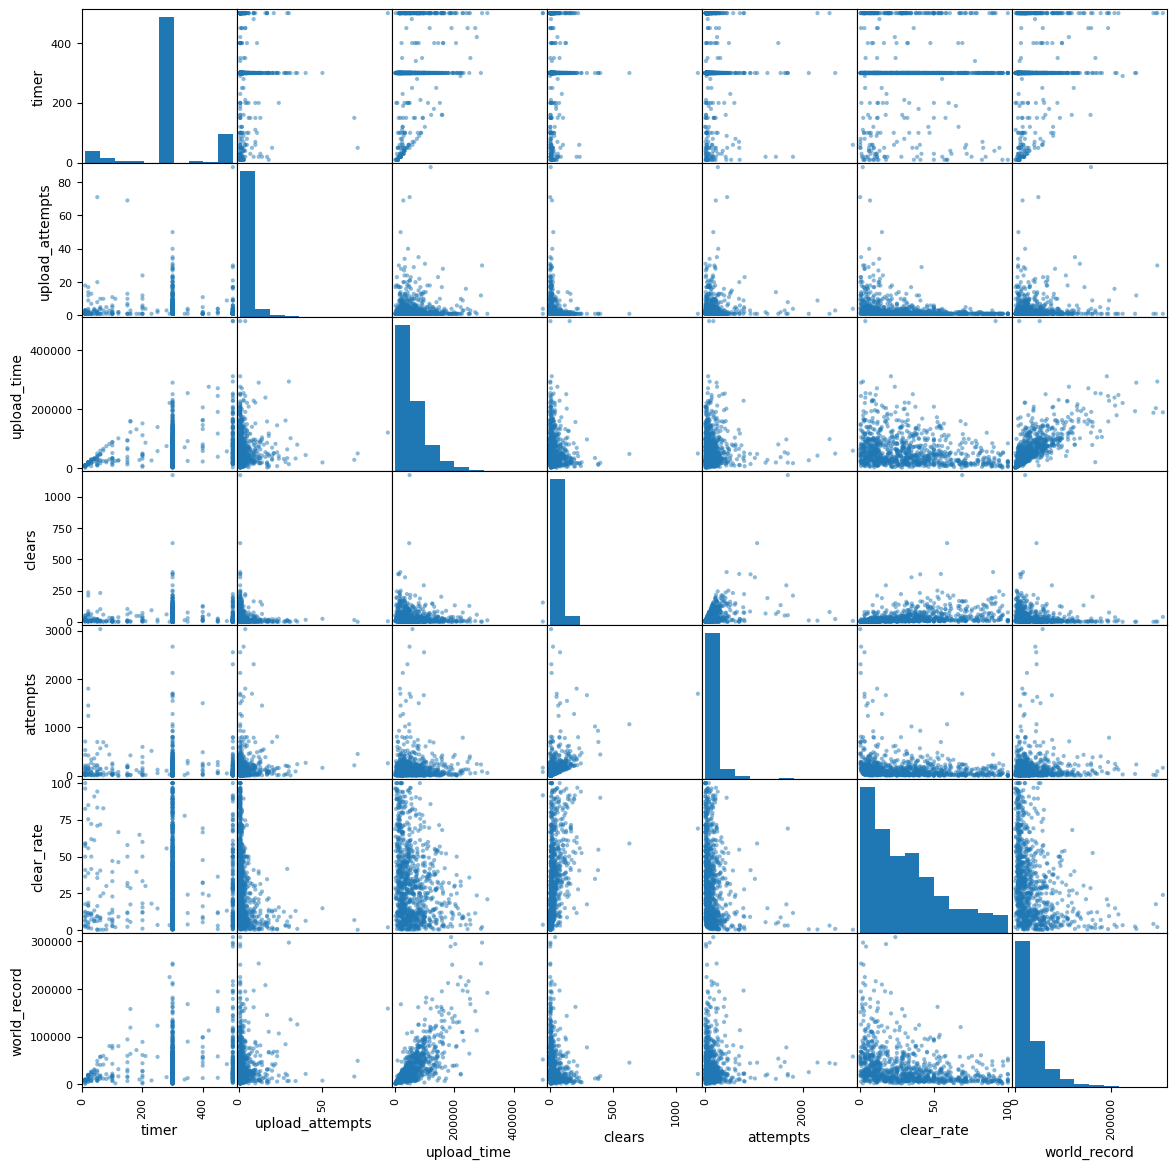

In [ ]:
pd.plotting.scatter_matrix(level_data_2, figsize=(14,14))

Cutting points from attempts doesn't seem to help the shape of the attempts data become more meaningful. The attempts will be transformed via log function instead.

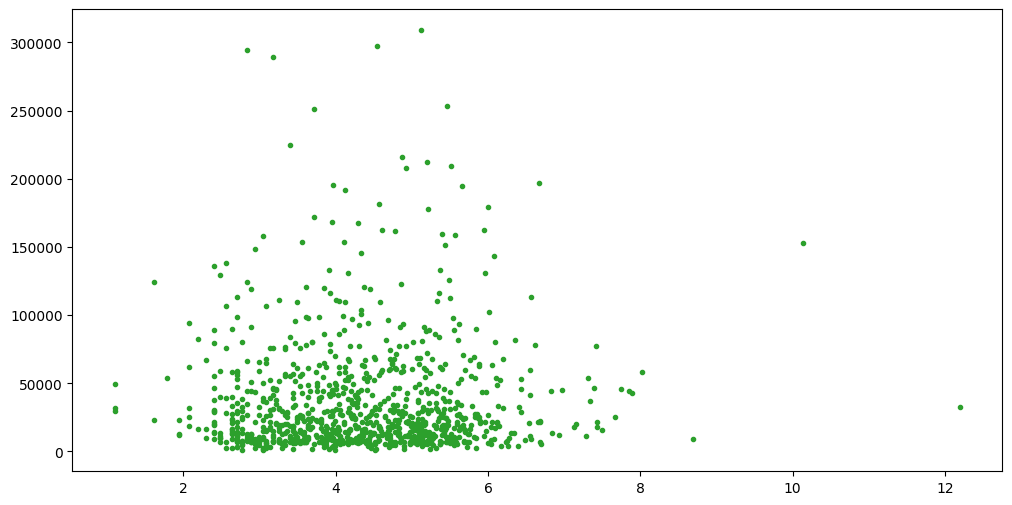

In [ ]:
#Plot the transformed attempts data
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
#raw data
ax.plot(np.log(level_data_df.attempts), level_data_df.world_record, "C2.", zorder=-3)

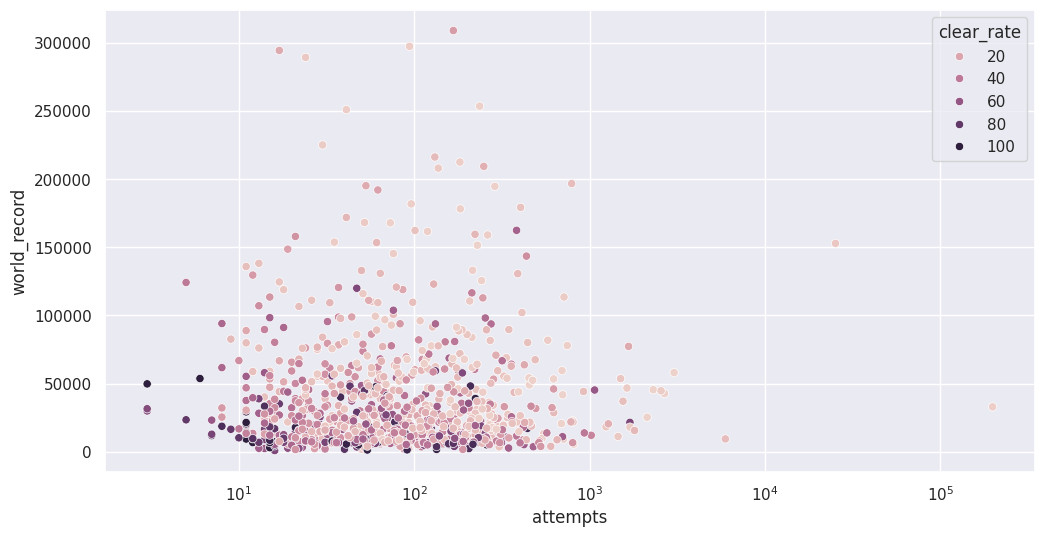

In [ ]:
sb.set_theme(rc={'figure.figsize':(12,6)})
sb.scatterplot(data=level_data_df, x="attempts", y="world_record", hue="clear_rate")
plt.xscale('log')

Using log to transform the attempts data did not produce points with a trend, so attempts seems to not be a good predictor. Next, timer vs world record time will be checked.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


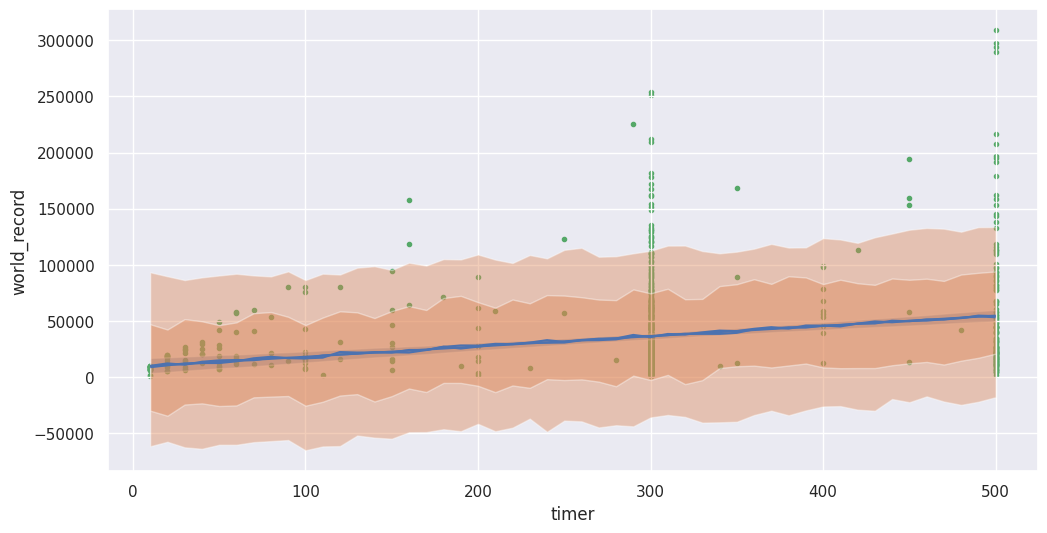

In [ ]:
#Plot two HDIs
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
#mean line
bmb.interpret.plot_predictions(single_models['world_record ~ timer'][0], single_models['world_record ~ timer'][1], "timer", ax=ax, fig_kwargs={"color":"k"})
#94% HDI
bmb.interpret.plot_predictions(single_models['world_record ~ timer'][0], single_models['world_record ~ timer'][1], "timer", pps=True, ax=ax)
#65% HDI
ax_ = bmb.interpret.plot_predictions(single_models['world_record ~ timer'][0], single_models['world_record ~ timer'][1], "timer", pps=True, ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')

#raw data
ax.plot(level_data_df.timer, level_data_df.world_record, "C2.", zorder=-3)

Timer was checked because the distribution for the data was odd, since two of the values, 300 and 500, were far more popular than other options. Upon plotting the mean line, it seemed that popularity obscured any other relationships that may exist between timer and world record.

Next, the reference model will be created with all predictors and no interactions. This will be compared to the single variable models.

In [29]:
#Get the idata for the reference model
ref_model = bmb.Model("world_record ~ autoscroll_speed + clear_condition + timer + gamestyle + tags + upload_attempts + upload_time + clears + attempts + clear_rate", data=level_data_df)
ref_idata = ref_model.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
#single_idatas = dict(zip(single_models.keys(), (v[1] for v in single_models.values())))
single_ref_compare = az.compare(single_idatas | {"Reference":ref_idata})
single_ref_compare

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Reference,0,-11384.467146,126.942369,0.000000,3.400519e-01,55.062789,0.000000,True,log
world_record ~ upload_time,1,-11422.084494,20.911521,37.617348,6.243515e-01,71.636248,38.841699,True,log
world_record ~ tags,2,-11688.320229,65.987859,303.853083,2.442091e-10,49.518605,50.602019,True,log
world_record ~ clear_rate,3,-11691.082560,7.865771,306.615414,3.559661e-02,54.545391,57.712836,False,log
world_record ~ timer,4,-11715.199222,8.461078,330.732077,0.000000e+00,52.428591,54.769419,False,log
world_record ~ clear_condition,5,-11717.989626,39.970354,333.522481,1.287725e-11,52.126269,52.270414,True,log
world_record ~ gamestyle,6,-11725.440661,11.077243,340.973515,2.348360e-10,53.674214,55.858744,False,log
world_record ~ upload_attempts,7,-11741.828958,8.775213,357.361812,1.621086e-12,54.345090,57.219094,False,log
world_record ~ clears,8,-11745.569908,8.784777,361.102762,2.082971e-12,54.665108,57.032742,True,log
world_record ~ attempts,9,-11745.601489,7.764775,361.134343,0.000000e+00,54.444815,56.889253,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

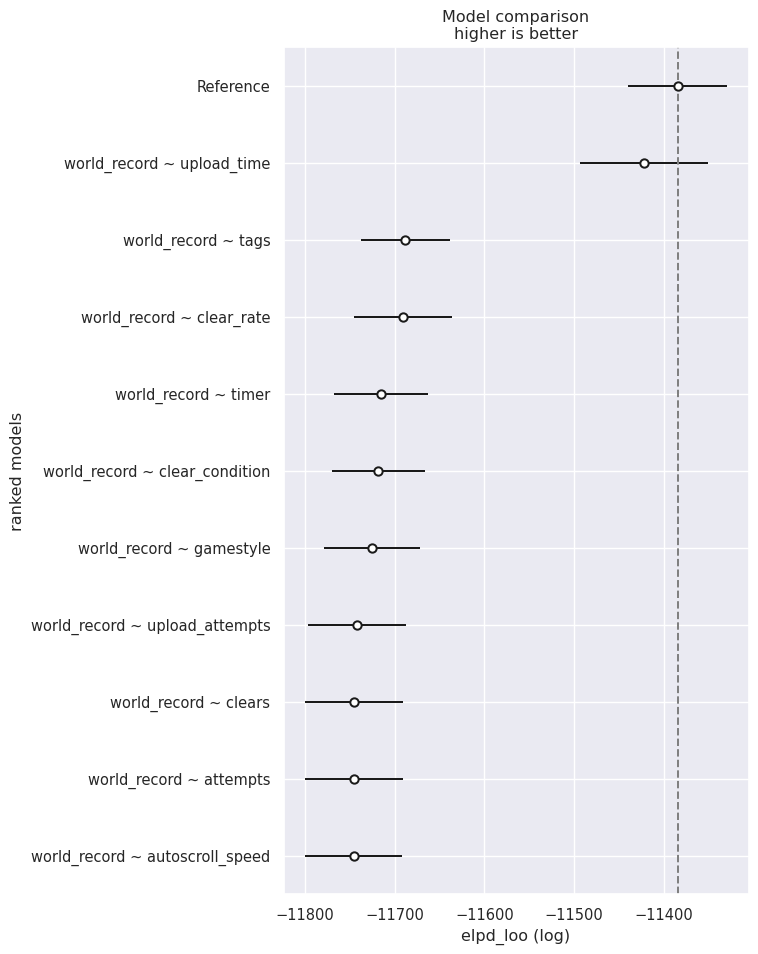

In [ ]:
az.plot_compare(single_ref_compare)

The standard error bounds overlap for the elpd_loos of the upload time and reference models, so the reference is not clearly better than the upload time model. Next, a model will be run with the initially supposed strong interactions between the predictors.

In [ ]:
#Get the idata for the model with initially imagined interactions except weak ones
strong1_model = bmb.Model("world_record ~ autoscroll_speed + clear_condition + timer + tags + upload_attempts + upload_time + clears + clear_rate" +
                      " + autoscroll_speed:tags + autoscroll_speed:upload_time" +
                      " + clear_condition:clears + clear_condition:upload_time" +
                      " + timer:tags + timer:clears + timer:upload_time" +
                      " + tags:clears + tags:upload_time" +
                      " + upload_attempts:clears" +
                      " + clears:upload_time + clears:clear_rate" +
                      " + attempts:clear_rate", data=level_data_df)
strong1_idata = strong1_model.fit(idata_kwargs={"log_likelihood":True})

/usr/local/lib/python3.11/dist-packages/bambi/priors/scaler.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  return self.STD * (self.response_std / np.std(x))


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'sigma_log__': array(10.59138719), 'Intercept': array(36801.22738937), 'autoscroll_speed': array([ 0.06512209, -0.99942597]), 'clear_condition': array([-0.27684904,  0.21490455,  0.61533541,  0.99744351,  0.39808815,
        0.28900125, -0.91501958, -0.62130305, -0.59737166, -0.49840766,
       -0.0574611 ,  0.28916207,  0.46259442, -0.71461276,  0.96913187,
       -0.41957989, -0.6926582 ,  0.50721344,  0.94144074, -0.61019884,
       -0.14526615, -0.17673266, -0.29561165,  0.54104037, -0.07009918,
       -0.58428075,  0.67006481,  0.70830781, -0.6344902 ,  0.15036747,
       -0.50317816,  0.64484814,  0.52148399, -0.20324029,  0.78442225,
        0.77037036,  0.49103605,  0.93200637, -0.72071119,  0.58376408,
       -0.54666281, -0.90776967,  0.58764806, -0.26491165]), 'timer': array(-0.14447061), 'tags': array([ 0.42613312,  0.97103126,  0.99800571,  0.96422272,  0.65391531,
       -0.29285887, -0.43552758,  0.97618541, -0.5098259 ,  0.17146745,
        0.70873724, -0.99934937, -0.92141323,  0.76431774, -0.39304656,
       -0.26976322,  0.78076688, -0.58635681, -0.52563285, -0.58974734,
        0.10125793,  0.64270744,  0.08405037, -0.63657562,  0.22661254,
        0.99584608,  0.76019177,  0.79097072,  0.68224802, -0.05359353,
       -0.54892024, -0.84607915, -0.32189656, -0.66268252,  0.34219933,
       -0.47804013,  0.52817339,  0.93254175, -0.54210419,  0.50073125,
       -0.86479554,  0.64658147, -0.56411363,  0.85692498, -0.36191794,
       -0.90350198,  0.99339284, -0.09806644, -0.77062881, -0.00882416,
        0.31123263,  0.80464341, -0.66331248,  0.44634601,  0.61190318,
       -0.56689821,  0.12529125, -0.84200391,  0.63900641, -0.98561952,
       -0.69105124,  0.23172428,  0.80863309, -0.26904181,  0.32483447,
        0.02725193]), 'upload_attempts': array(0.76603137), 'upload_time': array(-0.10746975), 'clears': array(0.25274857), 'clear_rate': array(-0.83044121), 'autoscroll_speed:tags': array([-0.00233126, -0.22342421,  0.11894253, -0.82323272,  0.29976413,
        0.90824255,  0.00452032,  0.32814936,  0.89663579,  0.82259911,
       -0.15031082, -0.2786169 ,  0.55272402,  0.60787949,  0.14845476,
       -0.08536636,  0.17932736,  0.89109635,  0.68333397, -0.8080692 ,
        0.7476647 , -0.29595341, -0.7064042 , -0.61547179,  0.78910298,
       -0.77616601,  0.28191644, -0.64770405, -0.28608145,  0.34270959,
        0.03212985, -0.47657657,  0.15692441, -0.903814  ,  0.9967202 ,
       -0.80717262, -0.43536438,  0.75185487,  0.84007438,  0.77439512,
       -0.19479352, -0.46244609,  0.19198903,  0.62301609, -0.39853538,
        0.70746934,  0.81303926,  0.37467236, -0.12301198, -0.99755826,
        0.70130754, -0.8360423 ,  0.65265425,  0.87252475,  0.78784   ,
       -0.32094312, -0.68890007, -0.1788179 ,  0.13911614,  0.46776428,
       -0.77957841, -0.80874932, -0.88950483,  0.13870339,  0.11309719,
        0.65772819,  0.59149285, -0.80281626, -0.71752257, -0.32587656,
        0.24845245,  0.99983034,  0.85984757, -0.37611112,  0.02005428,
        0.84944005,  0.66333562, -0.12241936, -0.89388511,  0.45404709,
        0.48342596,  0.73756807,  0.94813761, -0.87316677,  0.84421965,
       -0.37230974, -0.24499221,  0.82845138,  0.483655  , -0.58882753,
       -0.88161114, -0.48341462, -0.98797444, -0.94021348,  0.93117794,
       -0.45289813,  0.70765561,  0.26958126,  0.94240065,  0.19291935,
        0.47454251, -0.68578072, -0.48618284,  0.82389511,  0.98633268,
       -0.51375114, -0.80113851, -0.32654435, -0.65222023,  0.0446045 ,
       -0.36571924,  0.28296277, -0.85510405, -0.94633919,  0.10226566,
        0.60272492,  0.63141668, -0.76846748, -0.13358687, -0.05583772,
        0.88290651, -0.07145519,  0.35082014, -0.17725921, -0.47297556,
        0.32242154, -0.40669853, -0.44435466, -0.45040755,  0.02331381,
        0.91083046, -0.08888911]), 'autoscroll_speed:upload_time': array([-0.51941719,  0.69587498]), 'clear_condition:clears': array([-0.00605458, -0.30879748,  0.96228878,  0.00844402, -0.76463294,
        0.3129329 ,  0.76993558, -0.76046538,  0.52589584, -0.78236079,
        0.55375311,  0.01277489, -0.379865  , -0.95976248,  0.70790442,
       -0.46726468,  0.03365906, -0.94866863,  0.17327925, -0.49452304,
        0.22659303, -0.58168412,  0.10782714, -0.01815434, -0.96074807,
       -0.33096306, -0.95407571, -0.34694992,  0.60665255, -0.1811602 ,
       -0.46449487, -0.20520276,  0.6926015 ,  0.32337791,  0.29667664,
       -0.44985694,  0.81900641, -0.05415175, -0.73045033, -0.3965421 ,
        0.7074156 , -0.21119206,  0.75656339, -0.73374774]), 'clear_condition:upload_time': array([-0.10952224,  0.95206251, -0.11007651,  0.66079511, -0.12105887,
        0.44322132, -0.02961856, -0.33379567, -0.50370612, -0.34525773,
        0.46399927,  0.38589403, -0.72669746, -0.89932243, -0.21554925,
        0.4532893 ,  0.55041233,  0.02497844,  0.30039134,  0.73213075,
       -0.05109601, -0.27519946,  0.63261274,  0.1629353 , -0.76113739,
       -0.02536247,  0.91254119, -0.31304913,  0.52374314, -0.88447379,
        0.14924438, -0.77876055,  0.90698396, -0.87883233, -0.73468212,
       -0.62652702,  0.28332379,  0.99187616,  0.45769946,  0.3298975 ,
       -0.76671904,  0.97284732,  0.42414463,  0.12885151]), 'timer:tags': array([ 0.80014277, -0.80253601, -0.18790592,  0.93876192, -0.14281793,
        0.73033697,  0.12274265,  0.47165615,  0.49898423,  0.38120535,
        0.80326908,  0.18724749,  0.99235702,  0.33430609, -0.12497331,
       -0.66295198,  0.38328253, -0.71800711,  0.04408095, -0.61183665,
       -0.15078661, -0.57209431,  0.36351973,  0.99894308,  0.43258082,
       -0.42843318,  0.95209864, -0.23209686, -0.72314815,  0.37788487,
       -0.64205148, -0.48238192, -0.43368313, -0.81655277, -0.37001391,
       -0.48375435,  0.79389091,  0.15725269,  0.75779352, -0.14214783,
        0.21765522, -0.79750588,  0.39459195,  0.92579708,  0.62141123,
       -0.04658899,  0.45418461,  0.28581074,  0.28510029, -0.94148697,
       -0.51165692,  0.00978447, -0.22785336, -0.613198  ,  0.14793281,
        0.91434315, -0.70868022,  0.47040477, -0.52996169, -0.16982467,
       -0.48089291,  0.08734699,  0.41926874, -0.58522467,  0.98987104,
       -0.91897716]), 'timer:clears': array(-0.25018934), 'timer:upload_time': array(0.87414898), 'tags:clears': array([-0.65255634,  0.23459404, -0.11867891,  0.77963368, -0.85705051,
       -0.9823834 , -0.21384272,  0.28667279,  0.2356427 ,  0.13154331,
       -0.78656232, -0.57804728, -0.82096577,  0.82841484,  0.87674597,
        0.21360829,  0.80292382,  0.19774108,  0.10298273, -0.2561471 ,
        0.45776679, -0.60182773,  0.15646386,  0.4690699 , -0.73058807,
        0.03340017, -0.78444836, -0.94558634,  0.76635953, -0.9156455 ,
        0.92946474, -0.66755396,  0.35907505,  0.84209701, -0.28411523,
       -0.13931273,  0.54362796,  0.593343  ,  0.28696195, -0.05435028,
       -0.42969894, -0.31459859,  0.13984989, -0.02432665, -0.5512993 ,
       -0.20583381, -0.54753703, -0.2104484 , -0.67629371, -0.75616892,
        0.75700843,  0.26038292, -0.90429447, -0.54761911, -0.81658818,
        0.80336518,  0.82059182, -0.51973141,  0.14695307, -0.45776992,
        0.98942533,  0.81739657, -0.11097575,  0.35450943, -0.44696537,
        0.98945098]), 'tags:upload_time': array([-0.39330078,  0.17158006, -0.64193011, -0.33003463,  0.3799761 ,
       -0.58285812,  0.99061402, -0.76789377,  0.94382374, -0.86922288,
       -0.96582084,  0.32105891, -0.60091972,  0.52732451,  0.41972537,
        0.49702746, -0.49913963, -0.11285091,  0.33378755, -0.40879873,
       -0.98277117,  0.2851789 ,  0.58288435, -0.99667825, -0.99882289,
       -0.09559729,  0.32298177,  0.98867307,  0.26673315,  0.30168019,
       -0.23808655,  0.59260872, -0.55058086,  0.67982707, -0.64296905,
        0.82849721,  0.71723002,  0.64633486, -0.91257478,  0.36308545,
        0.94681694, -0.97246913, -0.14535058,  0.83112345,  0.90048433,
       -0.81612394, -0.47884592, -0.59738719,  0.33039139,  0.93125235,
        0.84013102, -0.43298949,  0.92141136,  0.32849929, -0.88960334,
       -0.53276319,  0.89138003, -0.68680445, -0.26706796, -0.01244298,
        0.90522661,  0.2478382 , -0.94733418, -0.08389059,  0.13804781,
       -0.13469597]), 'upload_attempts:clears': array(0.10100054), 'clears:upload_time': array(0.79960027), 'clears:clear_rate': array(0.7330285), 'attempts:clear_rate': array(0.91367212)}

Logp initial evaluation results:
{'sigma': -0.85, 'Intercept': -inf, 'autoscroll_speed': -30.33, 'clear_condition': -682.72, 'timer': -7.75, 'tags': -996.19, 'upload_attempts': -10.6, 'upload_time': -1.55, 'clears': -7.31, 'clear_rate': -9.23, 'autoscroll_speed:tags': -inf, 'autoscroll_speed:upload_time': -9.08, 'clear_condition:clears': -555.43, 'clear_condition:upload_time': -199.19, 'timer:tags': -618.14, 'timer:clears': -1.57, 'timer:upload_time': -20067.42, 'tags:clears': -743.99, 'tags:upload_time': -269.44, 'upload_attempts:clears': -7.02, 'clears:upload_time': -3985.32, 'clears:clear_rate': -4.14, 'attempts:clear_rate': -2.72, 'world_record': -186806747.14}
You can call `model.debug()` for more details.

In [ ]:
#Get the idata for the model with initially imagined interactions except weak ones
strong1_model = bmb.Model("world_record ~ autoscroll_speed + clear_condition + timer + tags + upload_attempts + upload_time + clears + clear_rate" +
                      " + autoscroll_speed:upload_time" +
                      " + clear_condition:clears + clear_condition:upload_time" +
                      " + timer:tags + timer:clears + timer:upload_time" +
                      " + tags:clears + tags:upload_time" +
                      " + upload_attempts:clears" +
                      " + clears:upload_time + clears:clear_rate" +
                      " + attempts:clear_rate", data=level_data_df)
strong1_idata = strong1_model.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
at_model = bmb.Model("world_record ~ autoscroll_speed + clear_condition + timer + tags + upload_attempts + upload_time + clears + clear_rate" +
                      " + autoscroll_speed:tags", data=level_data_df)
at_idata = at_model.fit(idata_kwargs={"log_likelihood":True})

/usr/local/lib/python3.11/dist-packages/bambi/priors/scaler.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  return self.STD * (self.response_std / np.std(x))


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'sigma_log__': array(11.56904508), 'Intercept': array(36800.6040849), 'autoscroll_speed': array([-0.33388617,  0.74318637]), 'clear_condition': array([ 0.57097992,  0.18425505, -0.18836699, -0.637617  , -0.65484575,
        0.46190877, -0.45989549, -0.41775098, -0.59506433,  0.90391179,
       -0.26732486,  0.52950549,  0.79698886, -0.59046825,  0.77857405,
       -0.38889569, -0.35539016,  0.10827896,  0.76612733, -0.27641128,
        0.91762842, -0.82514024, -0.80542372, -0.83904631, -0.87994901,
        0.54140384,  0.28089812, -0.6030728 , -0.38205943, -0.16195006,
       -0.1597468 ,  0.76511399, -0.659275  ,  0.33845571,  0.37425924,
       -0.71226236,  0.46350592,  0.25496798,  0.09956959, -0.10771682,
        0.42567802,  0.60029618, -0.37959547, -0.19702171]), 'timer': array(-0.66007269), 'tags': array([ 0.19711463, -0.02802256,  0.28578665,  0.87224593, -0.32288922,
       -0.16996917,  0.83163025, -0.84020951,  0.30417495, -0.74866822,
       -0.84557952, -0.49823362, -0.56253364, -0.87821544, -0.09524482,
        0.93539493,  0.27768037,  0.65789365,  0.04714152, -0.55265425,
        0.39526313,  0.12017051, -0.8463011 , -0.78461364, -0.67939973,
        0.51866368,  0.96751709,  0.78770194, -0.58203433, -0.1960498 ,
       -0.73529332, -0.47755328, -0.9808665 , -0.08204759,  0.99947545,
        0.11817172,  0.88360435,  0.59913654, -0.79334928,  0.01770179,
        0.67587913, -0.90963794, -0.31920218,  0.14392999, -0.95357161,
        0.68804038,  0.31918716,  0.72146014, -0.27215745, -0.64973619,
       -0.19384066,  0.98428619,  0.85839081,  0.99043534,  0.83295976,
       -0.78732217,  0.04382721,  0.52163799, -0.23455532, -0.18379809,
        0.19519025, -0.53563962, -0.63117979, -0.0547206 , -0.15770171,
        0.77473214]), 'upload_attempts': array(0.53638993), 'upload_time': array(-0.18202762), 'clears': array(-0.57171353), 'clear_rate': array(-0.39281032), 'autoscroll_speed:tags': array([-0.22504583,  0.32751578, -0.69573743,  0.59188644,  0.8653841 ,
        0.81715014, -0.47404272,  0.19551687,  0.7776345 ,  0.51600326,
        0.94833992, -0.74258331,  0.65709786,  0.39932891, -0.6514823 ,
        0.44798772, -0.11960981,  0.73766343, -0.54163021,  0.20253178,
        0.37478895, -0.52730967,  0.10768524, -0.34808063, -0.5277338 ,
       -0.49138033, -0.6060026 ,  0.46362301, -0.92487785,  0.25411358,
       -0.84214882,  0.35565764,  0.57240412,  0.18190935,  0.02380843,
       -0.89152514,  0.77366781, -0.90933642,  0.56915197,  0.37261182,
       -0.78832848,  0.57944488, -0.55933477, -0.48799782, -0.90342206,
       -0.25089227,  0.57929694, -0.51807297,  0.74204772,  0.89163684,
        0.66709401,  0.68498005, -0.0140664 , -0.16381766, -0.19989432,
       -0.53258593,  0.65209285,  0.94510613,  0.62136174, -0.54988771,
        0.95105294,  0.41062459,  0.13098409, -0.71201271,  0.1977273 ,
        0.76479976, -0.56011511, -0.92667487,  0.95261671, -0.06366456,
        0.23030757,  0.00349919,  0.66873692,  0.93867968, -0.61510764,
        0.61271654,  0.46354798,  0.72224698,  0.79104086, -0.87835818,
       -0.33496983, -0.01443516, -0.15485508, -0.51696602,  0.61660522,
       -0.28057337, -0.85627836,  0.78814333,  0.79612536,  0.88764328,
       -0.46970068, -0.02668626,  0.24180105,  0.8658878 , -0.05101029,
       -0.50021089,  0.94740285, -0.84669684,  0.779094  , -0.70504807,
       -0.58290686,  0.66794777,  0.7476882 , -0.86138914, -0.48399186,
       -0.78047352,  0.73873842, -0.98866376,  0.59802077,  0.14834049,
        0.47424533, -0.58068862, -0.94612291,  0.60924238, -0.8093311 ,
        0.13117973, -0.69335247,  0.8131123 , -0.37205735, -0.17698298,
        0.79489857, -0.54069792, -0.88360393, -0.39305812,  0.07819677,
       -0.69794899,  0.4373902 , -0.13526587,  0.74726731, -0.79883733,
        0.53843052, -0.45200315])}

Logp initial evaluation results:
{'sigma': -1.76, 'Intercept': -inf, 'autoscroll_speed': -30.33, 'clear_condition': -682.72, 'timer': -7.75, 'tags': -996.19, 'upload_attempts': -10.6, 'upload_time': -1.56, 'clears': -7.31, 'clear_rate': -9.23, 'autoscroll_speed:tags': -inf, 'world_record': -12268.27}
You can call `model.debug()` for more details.

In [ ]:
strong_compare = az.compare(single_idatas | {"Reference":ref_idata, "Supposed strong interactions":strong1_idata})
strong_compare

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Reference,0,-11384.467146,126.942369,0.000000,1.777965e-01,55.062789,0.000000,True,log
world_record ~ upload_time,1,-11422.084494,20.911521,37.617348,6.246712e-01,71.636248,38.841699,True,log
Supposed strong interactions,2,-11424.610524,278.317143,40.143378,1.654062e-01,44.103212,39.797813,True,log
world_record ~ tags,3,-11688.320229,65.987859,303.853083,5.945858e-10,49.518605,50.602019,True,log
world_record ~ clear_rate,4,-11691.082560,7.865771,306.615414,3.212614e-02,54.545391,57.712836,False,log
world_record ~ timer,5,-11715.199222,8.461078,330.732077,1.106118e-10,52.428591,54.769419,False,log
world_record ~ clear_condition,6,-11717.989626,39.970354,333.522481,1.398257e-10,52.126269,52.270414,True,log
world_record ~ gamestyle,7,-11725.440661,11.077243,340.973515,3.608077e-15,53.674214,55.858744,False,log
world_record ~ upload_attempts,8,-11741.828958,8.775213,357.361812,3.598378e-11,54.345090,57.219094,False,log
world_record ~ clears,9,-11745.569908,8.784777,361.102762,6.057465e-11,54.665108,57.032742,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

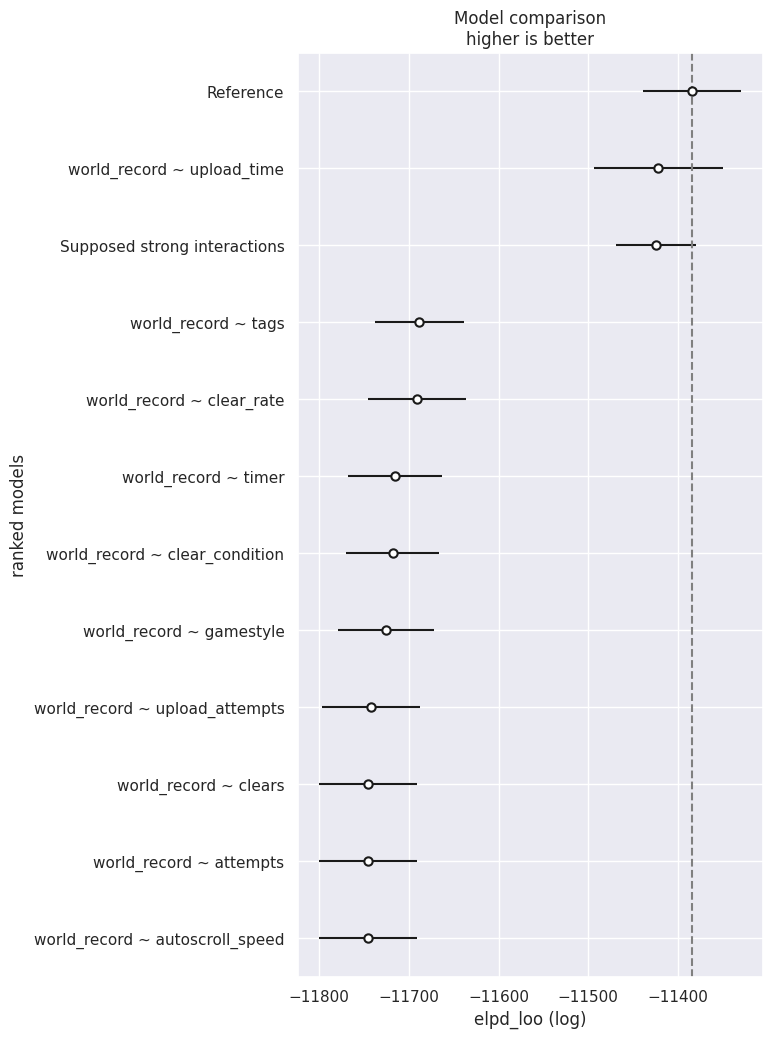

In [ ]:
az.plot_compare(strong_compare)

The model with the initially supposed interactions did not do much better than the reference model or the single variable upload time model. Considering most of the single variable models did similarly well, and the model posteriors that were graphed above reveal those models didn't predict very well, it makes sense that creating interactions wouldn't help a model do far better than the reference. Next, the posteriors and posterior predictive check for the model with interactions will be plotted.

/usr/local/lib/python3.11/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  warnings.warn(


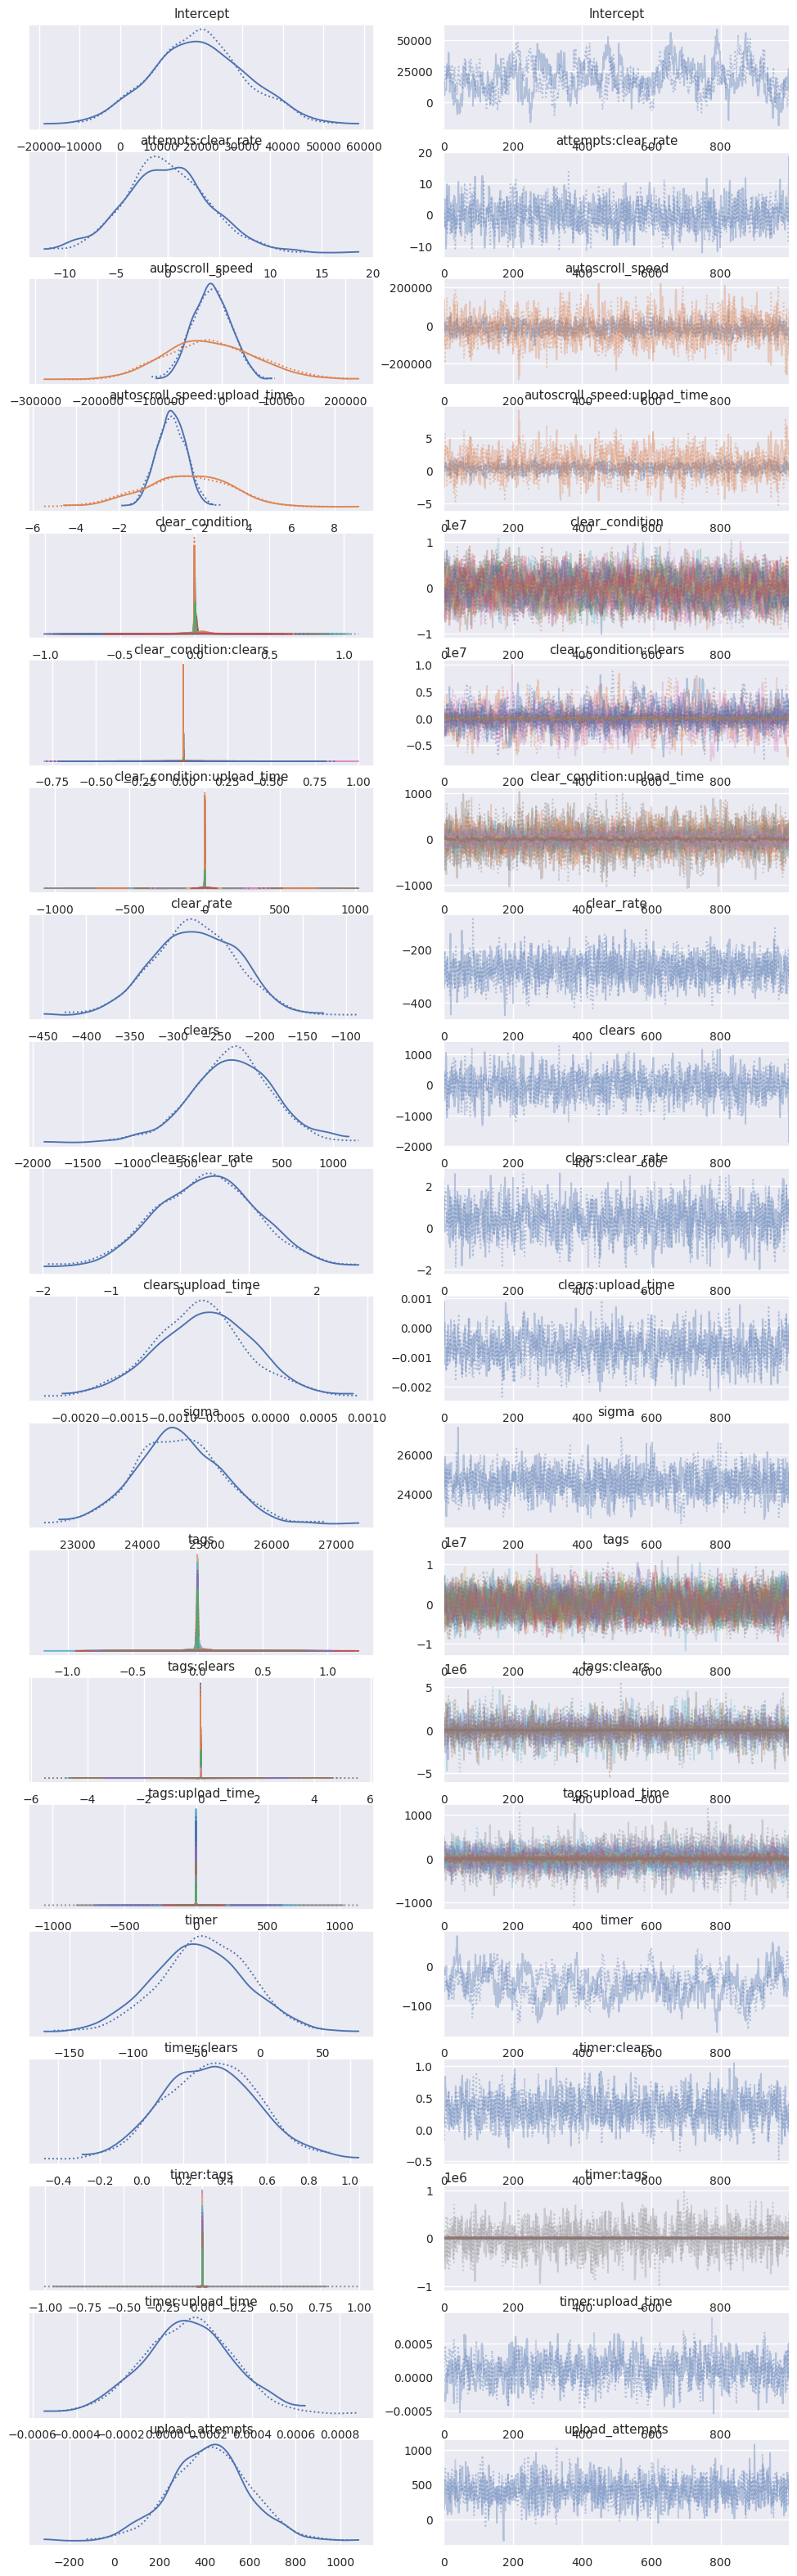

In [ ]:
az.plot_trace(strong1_idata);

In [ ]:
strong1_model.predict(strong1_idata, kind="response")

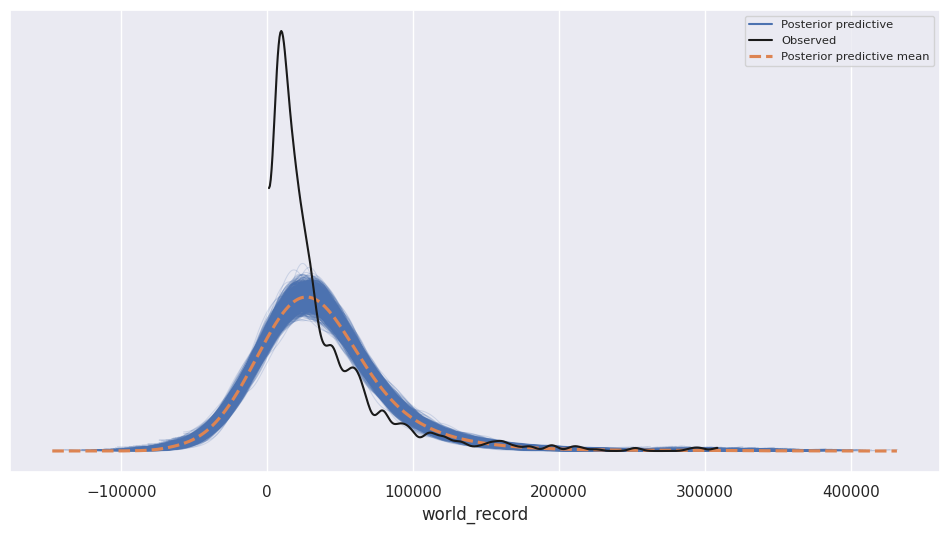

In [ ]:
az.plot_ppc(strong1_idata);

Upon inspection, the posterior predictive check reveals a normal likelihood may not have been the best choice for the model, as the observed world record distribution has no negative numbers and has a high peak that the normal distribution is not capturing. As the model with interactions took an hour to process, it will not be rerun unless it seems there could be a significant difference in predictive efficacy. The reference model would next be rerun with a different likelihood, but bambi would not run such a model with gamma, exponential, or negative binomial likelihoods.

In [25]:
#Get the idata for the reference model with a negative binomial likelihood
ut_prior = bmb.Prior("Normal", mu=0, sigma=1)
ref_hn_priors = {"upload_time": ut_prior}
ref_hn_model = bmb.Model("world_record ~ autoscroll_speed + clear_condition + timer + gamestyle + tags + upload_attempts + upload_time + clears + attempts + clear_rate", data=level_data_df, priors=ref_hn_priors, family="negativebinomial")
ref_hn_idata = ref_hn_model.fit(idata_kwargs={"log_likelihood":True})

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'alpha_log__': array(0.51659541), 'Intercept': array(0.94156032), 'autoscroll_speed': array([-0.44471201, -0.91167514]), 'clear_condition': array([-0.08435133, -0.12875463,  0.92260933,  0.99938949, -0.9110529 ,
       -0.10552541,  0.0367254 ,  0.20633296,  0.16512862, -0.02915462,
        0.47301718,  0.08665432, -0.10970289, -0.240772  ,  0.90654156,
        0.37907444,  0.72674806,  0.97192758,  0.96999399, -0.15611691,
        0.03574507,  0.8634678 ,  0.11064728, -0.32519782, -0.88007764,
       -0.57091476,  0.2413976 ,  0.23445692,  0.34546424, -0.68313553,
       -0.71519753,  0.00902571,  0.35446463,  0.53701775, -0.70169617,
       -0.65099228,  0.47958011, -0.86436649,  0.2902938 , -0.77054789,
       -0.42506903,  0.99398799, -0.2682789 ,  0.20439319]), 'timer': array(-0.04125753), 'gamestyle': array([-0.43807075,  0.78623716, -0.43034496, -0.56806876]), 'tags': array([ 0.51137205,  0.71797   , -0.64985911, -0.69763241, -0.275386  ,
       -0.85369856, -0.23218619, -0.6367226 , -0.58687293, -0.28344144,
        0.65859857,  0.66494804, -0.1158826 ,  0.49084478,  0.93486115,
        0.64550685,  0.04104594,  0.75470195,  0.02010527, -0.71316186,
        0.71111671,  0.97637659, -0.59153411, -0.18814385, -0.57609389,
       -0.47685735,  0.11013462,  0.56416869, -0.57745488, -0.22530052,
        0.43341197,  0.34476976,  0.20200129,  0.07484098,  0.52487772,
       -0.49490395,  0.01625627,  0.5938191 , -0.44139061, -0.63618684,
        0.15107145, -0.91440909, -0.10381745,  0.07947424,  0.05935877,
        0.90666321,  0.3406891 ,  0.09869105, -0.99415015, -0.92636824,
       -0.932388  ,  0.64595117, -0.03545295, -0.72209317, -0.91921179,
        0.37271439, -0.22081902, -0.96338631, -0.69448673, -0.19031577,
        0.61760146, -0.94278434, -0.24571588,  0.51163435,  0.65979493,
        0.46615938]), 'upload_attempts': array(0.78128174), 'upload_time': array(0.50291532), 'clears': array(0.35428162), 'attempts': array(-0.40102223), 'clear_rate': array(0.18806445)}

Logp initial evaluation results:
{'alpha': -1.27, 'Intercept': -3.1, 'autoscroll_speed': -9.06, 'clear_condition': -214.82, 'timer': 1.18, 'gamestyle': -11.33, 'tags': -294.35, 'upload_attempts': -2.02, 'upload_time': -1.05, 'clears': -299.36, 'attempts': -527349.45, 'clear_rate': -0.43, 'world_record': -inf}
You can call `model.debug()` for more details.

In [26]:
#Get the idata for the reference model with an exponential likelihood
ut_prior = bmb.Prior("Normal", mu=0, sigma=1)
ref_hn_priors = {"upload_time": ut_prior}
ref_hn_model = bmb.Model("world_record ~ autoscroll_speed + clear_condition + timer + gamestyle + tags + upload_attempts + upload_time + clears + attempts + clear_rate", data=level_data_df, priors=ref_hn_priors, family="exponential")
ref_hn_idata = ref_hn_model.fit(idata_kwargs={"log_likelihood":True})

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'Intercept': array(-0.88530733), 'autoscroll_speed': array([0.29172199, 0.14502349]), 'clear_condition': array([ 0.09405181, -0.12829078, -0.37159619, -0.80887537,  0.84914385,
       -0.61632725,  0.75396055, -0.84899292, -0.59200397,  0.9959233 ,
        0.30770572,  0.18945362,  0.04731617, -0.45504449, -0.92673805,
       -0.4279344 ,  0.39167811, -0.64005624,  0.63263955, -0.57798944,
        0.21733171, -0.56380478,  0.98471116,  0.22218065,  0.34714438,
        0.67948541, -0.66129989,  0.83925129, -0.09155289, -0.3871412 ,
        0.60445401, -0.49091754, -0.58449185, -0.17514288,  0.42985339,
       -0.09970868, -0.91066216, -0.63590106,  0.30076598,  0.06992947,
        0.00496574,  0.98923993,  0.91368046,  0.26574301]), 'timer': array(0.70333078), 'gamestyle': array([-0.17489786,  0.55866118, -0.15728855,  0.4562123 ]), 'tags': array([ 0.28784091, -0.48231352, -0.97596049, -0.67073709, -0.52195086,
       -0.47220223,  0.71187867, -0.23467931,  0.48777085, -0.91012702,
        0.83157981,  0.06191016, -0.61004072, -0.22730407, -0.21295374,
        0.37395188, -0.25060329, -0.24316437, -0.5916878 , -0.24045147,
       -0.77903981, -0.65743706,  0.76431199, -0.77997725,  0.10469808,
        0.05095722,  0.71978666, -0.33226076,  0.26196299,  0.73285563,
       -0.35456439,  0.55219382, -0.11540559,  0.41418118,  0.74366968,
       -0.73790179, -0.11893386, -0.2036168 , -0.19658741, -0.56231486,
        0.65049639, -0.6953812 ,  0.61499042, -0.1946843 , -0.14307895,
        0.03246683,  0.34000432,  0.55173533, -0.3266487 , -0.17200002,
        0.35369112,  0.30673142,  0.87213813, -0.04685105, -0.85200719,
        0.70637407,  0.43406823,  0.72437217,  0.19407905,  0.96599475,
       -0.49621503, -0.02574173,  0.64278886,  0.58977325, -0.28242546,
        0.30603315]), 'upload_attempts': array(-0.31679657), 'upload_time': array(-0.65388403), 'clears': array(0.23307143), 'attempts': array(0.46640537), 'clear_rate': array(0.39232702)}

Logp initial evaluation results:
{'Intercept': -3.1, 'autoscroll_speed': -9.06, 'clear_condition': -214.82, 'timer': -489.73, 'gamestyle': -11.32, 'tags': -294.35, 'upload_attempts': -0.3, 'upload_time': -1.13, 'clears': -127.68, 'attempts': -713329.46, 'clear_rate': -6.57, 'world_record': -inf}
You can call `model.debug()` for more details.

In [27]:
#Get the idata for the reference model with a gamma likelihood
ut_prior = bmb.Prior("Normal", mu=0, sigma=1)
ref_hn_priors = {"upload_time": ut_prior}
ref_hn_model = bmb.Model("world_record ~ autoscroll_speed + clear_condition + timer + gamestyle + tags + upload_attempts + upload_time + clears + attempts + clear_rate", data=level_data_df, priors=ref_hn_priors, family="gamma")
ref_hn_idata = ref_hn_model.fit(idata_kwargs={"log_likelihood":True})

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'alpha_log__': array(0.8546825), 'Intercept': array(-0.98625309), 'autoscroll_speed': array([0.0311796 , 0.66742125]), 'clear_condition': array([-0.82369891, -0.13511969,  0.34732754, -0.24626624,  0.76815551,
       -0.82468781, -0.59476203,  0.48977562,  0.09898442, -0.41584742,
        0.44591078,  0.17260405,  0.615977  , -0.53281445, -0.4689963 ,
        0.28832264,  0.14370751, -0.0940011 , -0.22486221, -0.55570953,
        0.62981262,  0.00955876, -0.13922895,  0.33745945, -0.63831943,
        0.49756304, -0.56479484, -0.23016546, -0.42909571,  0.80604196,
        0.16448987, -0.25491051, -0.22038851, -0.93700008, -0.97719841,
       -0.13137354, -0.46001511, -0.29108612, -0.4445416 ,  0.35911057,
       -0.32397951,  0.81558165,  0.71543751, -0.03007754]), 'timer': array(0.94642756), 'gamestyle': array([-0.29260082,  0.46867457, -0.66231849,  0.5258689 ]), 'tags': array([ 0.31108361, -0.67157592, -0.22767276,  0.70161337, -0.03832819,
        0.72571808, -0.8523954 ,  0.36634988, -0.7128301 , -0.82197123,
       -0.22758431,  0.12117362,  0.56634879, -0.31896397, -0.21247235,
        0.88444508, -0.95416631,  0.95609874, -0.72285397,  0.69520247,
       -0.27926855,  0.4686412 , -0.90988297,  0.1399059 , -0.10213972,
       -0.86814201,  0.96675576, -0.16883826, -0.91636944,  0.86894494,
        0.81466227,  0.12877563, -0.40374124, -0.5131912 , -0.17927531,
       -0.10148375,  0.97014252, -0.25382426, -0.08293774,  0.13123174,
        0.33260853,  0.49731119,  0.07772784,  0.03078164,  0.4693031 ,
        0.97548957,  0.82414719, -0.44679789, -0.57164026, -0.97830611,
       -0.95155611, -0.91090547,  0.95313502, -0.02087416,  0.03476889,
        0.14914779,  0.72682276,  0.63058892,  0.92796117,  0.70237731,
       -0.73915759, -0.04246768,  0.81955552, -0.53191028,  0.41197113,
        0.52905015]), 'upload_attempts': array(-0.4205941), 'upload_time': array(-0.0691605), 'clears': array(-0.56116791), 'attempts': array(0.17195374), 'clear_rate': array(0.03880862)}

Logp initial evaluation results:
{'alpha': -1.47, 'Intercept': -3.1, 'autoscroll_speed': -9.06, 'clear_condition': -214.82, 'timer': -889.1, 'gamestyle': -11.33, 'tags': -294.36, 'upload_attempts': -0.56, 'upload_time': -0.92, 'clears': -756.09, 'attempts': -96952.61, 'clear_rate': 1.32, 'world_record': -inf}
You can call `model.debug()` for more details.

In [30]:
ref_model

       Formula: world_record ~ autoscroll_speed + clear_condition + timer + gamestyle + tags + upload_attempts + upload_time + clears + attempts + clear_rate
        Family: gaussian
          Link: mu = identity
  Observations: 974
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 36801.2033, sigma: 384277.7819)
            autoscroll_speed ~ Normal(mu: [0. 0.], sigma: [1623603.9184 1452944.6257])
            clear_condition ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
                0. 0.
             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma: [1229231.5443 3242197.9991
                 904820.8166 3242197.9991 2293759.1988
             3242197.9991 3242197.9991 2293759.1988 1327035.8322 2293759.1988
             1873810.6857 3242197.9991 1150435.8237 3242197.9991 3242197.9991
             3242197.9991 3242197.9991 3242197.9991 2293759.1988 2293759.1988
             3242197.99

In [28]:
ref_hn_model

       Formula: world_record ~ autoscroll_speed + clear_condition + timer + gamestyle + tags + upload_attempts + upload_time + clears + attempts + clear_rate
        Family: gamma
          Link: mu = inverse
  Observations: 974
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 8.8335)
            autoscroll_speed ~ Normal(mu: [0. 0.], sigma: [39.0916 34.9826])
            clear_condition ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
                0. 0.
             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma: [29.5963 78.0625 21.7854
                 78.0625 55.2269 78.0625 78.0625 55.2269 31.9511
             55.2269 45.1158 78.0625 27.6991 78.0625 78.0625 78.0625 78.0625 78.0625
             55.2269 55.2269 78.0625 78.0625 55.2269 39.0916 21.7854 45.1158 78.0625
             24.8005 55.2269 78.0625 17.2125 45.1158 78.0625 55.2269 55.2269 78.0625
             78.0625

# Conclusion

While it was initially believed that each of the ten predictors would affect world record time, it appears that the majority of them are actually weak predictors and have weak interactions amongst themselves. A model solely ba sed on upload time predicts similarly well to a model with every predictor. There still may be patterns in the effects of certain predictors on world record time, but the data is likely too noisy or influenced by too many unobserved confounding variables for those patterns to be meaningful to a world record time prediction model such as this one. The exact structure of a level itself is what determines the fastest possible completion time, but the 10 predictors used here do not seem to be good representations of aspects of that relationship.